X:torch.Size([500, 302])
Y:torch.Size([500, 302])
mask:torch.Size([302])
time:torch.Size([500])
X:torch.Size([500, 302])
Y:torch.Size([500, 302])
mask:torch.Size([302])
time:torch.Size([500])


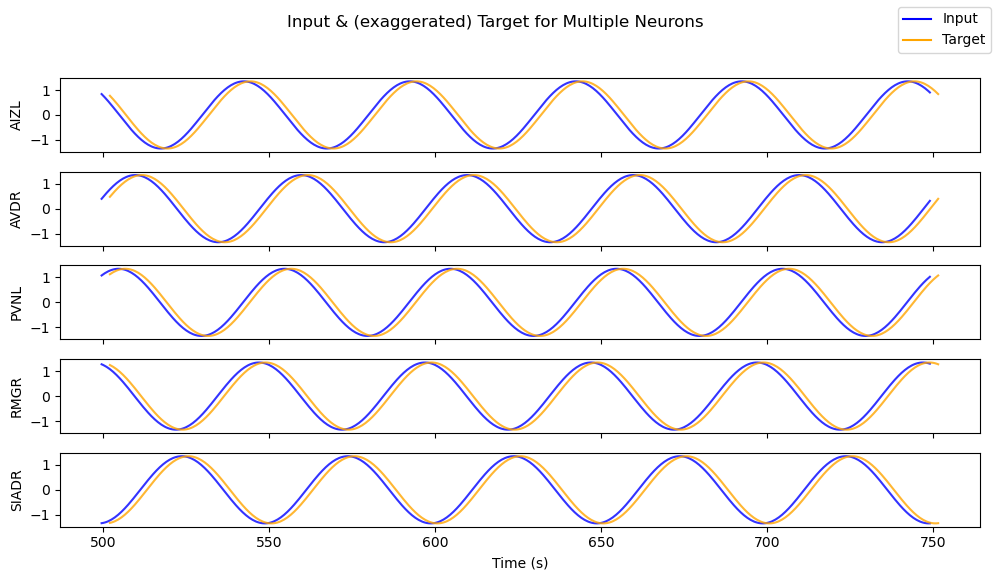

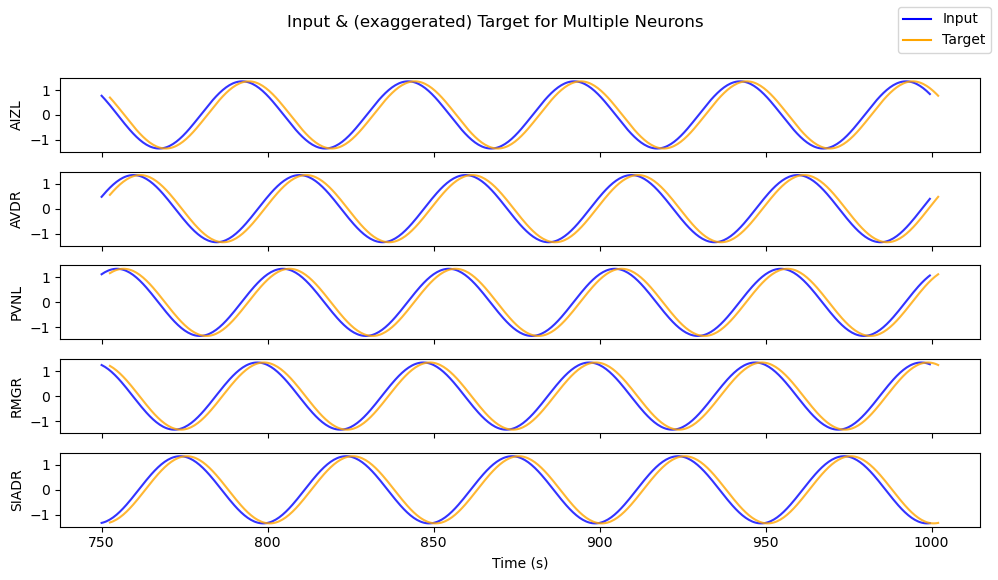

In [3]:
"""
Tests whether the dataset and 
data loader generates samples 
and batches, respectively, as expected.
"""

import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from utils import NEURONS_302
from data._utils import create_combined_dataset, split_combined_dataset

# Silence warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Create a single dataset combining all the worms from the two synthetic datasets
datasets = dict(Sines0000="all", Lorenz0000="all")
combined_dataset, dataset_info = create_combined_dataset(datasets, "all")

# Split the datsaet into train and validation halves
num_train_samples = num_val_samples = 2
reverse = use_residual = False
smooth_data = True
seq_len = 500
train_dataset, val_dataset, timestep_info = split_combined_dataset(
    combined_dataset,
    num_train_samples,
    num_val_samples,
    seq_len,
    reverse,
    use_residual,
    smooth_data,
)

# Get a sample from the train dataset
X_train, Y_train, mask_train, meta_train = train_dataset[1]
time_train = meta_train["time_vec"]
print(
    f"X:{X_train.shape}\nY:{Y_train.shape}\nmask:{mask_train.shape}\ntime:{time_train.shape}"
)

# Get a sample from the validation dataset
X_test, Y_test, mask_test, meta_test = val_dataset[0]
time_test = meta_test["time_vec"]
print(
    f"X:{X_test.shape}\nY:{Y_test.shape}\nmask:{mask_test.shape}\ntime:{time_test.shape}"
)

# Make a plot for each half of the dataset
for phase in ["train", "test"]:
    # Convert the data to NumPy arrays if they are not already
    time = eval(f"time_{phase}.numpy()")
    X = eval(f"X_{phase}.numpy()")
    Y = eval(f"Y_{phase}.numpy()")
    mask = eval(f"mask_{phase}.numpy()")

    # Get the indices of the neurons to plot
    neurons_to_plot = np.where(mask)[0]

    # Set offsets for the target data
    y_offset_step = 5
    x_offset = len(time) / 200

    # Initialize an empty list to collect DataFrame fragments
    data_fragments = []

    for i, neuron_idx in enumerate(neurons_to_plot):
        neuron_label = NEURONS_302[neuron_idx]

        # Collect input data
        input_df = pd.DataFrame(
            {
                "Time": time,
                "Value": X[:, neuron_idx],
                "Type": "Input",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(input_df)

        # Collect target data with time offset
        target_df = pd.DataFrame(
            {
                "Time": time
                + x_offset,  # Adjust the time if needed for display purposes
                "Value": Y[:, neuron_idx],
                "Type": "Target",
                "Neuron": neuron_label,
            }
        )
        data_fragments.append(target_df)

    # Concatenate all fragments to create the full DataFrame
    df = pd.concat(data_fragments, ignore_index=True)

    # Set up the matplotlib figure and axes
    fig, axes = plt.subplots(len(neurons_to_plot), 1, figsize=(10, 6), sharex=True)

    # Use Seaborn's lineplot for each subplot
    for i, neuron_label in enumerate(neurons_to_plot):
        ax = axes[i]
        sns.lineplot(
            data=df[df["Neuron"] == NEURONS_302[neuron_label]],
            x="Time",
            y="Value",
            hue="Type",
            ax=ax,
            palette=["blue", "orange"],  # You can choose better colors
            alpha=0.8,  # Set a higher alpha for visibility
        )

        ax.set_ylabel(NEURONS_302[neuron_label])
        ax.get_legend().remove()

    # Common attributes for all plots
    axes[-1].set_xlabel("Time (s)")
    plt.suptitle("Input & (exaggerated) Target for Multiple Neurons")

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Display the legend
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.show()